In [2]:
from __future__ import print_function
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
import keras
from tensorflow.keras import layers

from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format


In [3]:
keras.__version__

'2.2.4'

In [4]:
! ls

aa.ipynb		 equipment_success.csv	       mlcc-exercises_en.zip
demo.ipynb		 equipment_success_unique.csv
equipment-success.ipynb  mlcc-exercises


In [5]:

equipment_success_dataframe = pd.read_csv("./equipment_success_unique.csv", sep=",")

equipment_success_dataframe['decades_old'] = round(equipment_success_dataframe['age_in_months_at_equipped_start'] / 120)

def isMale(x):
    if x == "male":
        return 1
    return 0
def isFemale(x):
    if x == "female":
        return 1
    return 0
def isRightEar(x):
    if x == "R":
        return 1
    return 0
def isLeftEar(x):
    if x == "L":
        return 1
    return 0
def isBothEars(x):
    if x == "BIN":
        return 1
    return 0
def dbToAmp (x):
    return 10**(x/20)


equipment_success_dataframe['isMale'] = equipment_success_dataframe['gender'].apply(isMale)
equipment_success_dataframe['isFemale'] = equipment_success_dataframe['gender'].apply(isFemale)
equipment_success_dataframe['isRightEar'] = equipment_success_dataframe['ears'].apply(isRightEar)
equipment_success_dataframe['isLeftEar'] = equipment_success_dataframe['ears'].apply(isLeftEar)
equipment_success_dataframe['isBothEars'] = equipment_success_dataframe['ears'].apply(isBothEars)

'''
equipment_success_dataframe['freq_500'] = dbToAmp(equipment_success_dataframe['freq_500'])
equipment_success_dataframe['freq_1000'] = dbToAmp(equipment_success_dataframe['freq_1000'])
equipment_success_dataframe['freq_2000'] = dbToAmp(equipment_success_dataframe['freq_2000'])
equipment_success_dataframe['freq_4000'] = dbToAmp(equipment_success_dataframe['freq_4000'])
equipment_success_dataframe['eq_freq_500'] = dbToAmp(equipment_success_dataframe['eq_freq_500'])
equipment_success_dataframe['eq_freq_1000'] = dbToAmp(equipment_success_dataframe['eq_freq_1000'])
equipment_success_dataframe['eq_freq_2000'] = dbToAmp(equipment_success_dataframe['eq_freq_2000'])
equipment_success_dataframe['eq_freq_4000'] = dbToAmp(equipment_success_dataframe['eq_freq_4000'])
'''

equipment_success_dataframe['freq_500_over_freq_1000'] = equipment_success_dataframe['freq_500']/equipment_success_dataframe['freq_1000']
equipment_success_dataframe['freq_2000_over_freq_1000'] = equipment_success_dataframe['freq_2000']/equipment_success_dataframe['freq_1000']
equipment_success_dataframe['freq_4000_over_freq_1000'] = equipment_success_dataframe['freq_4000']/equipment_success_dataframe['freq_1000']


equipment_success_dataframe['freq_500_gain'] = equipment_success_dataframe['freq_500'] - equipment_success_dataframe['eq_freq_500']
equipment_success_dataframe['freq_1000_gain'] = equipment_success_dataframe['freq_1000'] - equipment_success_dataframe['eq_freq_1000']
equipment_success_dataframe['freq_2000_gain'] = equipment_success_dataframe['freq_2000'] - equipment_success_dataframe['eq_freq_2000']
equipment_success_dataframe['freq_4000_gain'] = equipment_success_dataframe['freq_4000'] - equipment_success_dataframe['eq_freq_4000']

equipment_success_dataframe['freq_500_gain_ratio'] = equipment_success_dataframe['freq_500_gain'] / equipment_success_dataframe['freq_500']
equipment_success_dataframe['freq_1000_gain_ratio'] = equipment_success_dataframe['freq_1000_gain'] / equipment_success_dataframe['freq_1000']
equipment_success_dataframe['freq_2000_gain_ratio'] = equipment_success_dataframe['freq_2000_gain'] / equipment_success_dataframe['freq_2000']
equipment_success_dataframe['freq_4000_gain_ratio'] = equipment_success_dataframe['freq_4000_gain'] / equipment_success_dataframe['freq_4000']

# equipment_success_dataframe['eq_gain_ratio'] = (-equipment_success_dataframe['eq_average_loss'] + equipment_success_dataframe['average_loss'])/equipment_success_dataframe['average_loss']


equipment_success_dataframe = equipment_success_dataframe.drop(columns=["eq_average_loss", "eq_high_loss", "eq_low_loss", "rk", "ears", "gender"])



In [6]:
equipment_success_dataframe['valid'] = (
    equipment_success_dataframe['freq_500'].apply(lambda x : not math.isnan(x)) &
    equipment_success_dataframe['freq_1000'].apply(lambda x : not math.isnan(x)) &
    equipment_success_dataframe['freq_2000'].apply(lambda x : not math.isnan(x)) &
    equipment_success_dataframe['freq_4000'].apply(lambda x : not math.isnan(x)) &
    equipment_success_dataframe['eq_freq_500'].apply(lambda x : not math.isnan(x)) &
    equipment_success_dataframe['eq_freq_1000'].apply(lambda x : not math.isnan(x)) &
    equipment_success_dataframe['eq_freq_2000'].apply(lambda x : not math.isnan(x)) &
    equipment_success_dataframe['eq_freq_4000'].apply(lambda x : not math.isnan(x)) &
    
    equipment_success_dataframe['freq_500_gain'].apply(lambda x : not math.isnan(x) and x > 0) &
    equipment_success_dataframe['freq_1000_gain'].apply(lambda x : not math.isnan(x) and x > 0) &
    equipment_success_dataframe['freq_2000_gain'].apply(lambda x : not math.isnan(x) and x > 0) &
    equipment_success_dataframe['freq_4000_gain'].apply(lambda x : not math.isnan(x) and x > 0) &

        equipment_success_dataframe['freq_500_gain_ratio'].apply(lambda x : not math.isnan(x) and x < 1) &
        equipment_success_dataframe['freq_1000_gain_ratio'].apply(lambda x : not math.isnan(x) and x < 1) &
        equipment_success_dataframe['freq_2000_gain_ratio'].apply(lambda x : not math.isnan(x) and x < 1) &
        equipment_success_dataframe['freq_4000_gain_ratio'].apply(lambda x : not math.isnan(x) and x < 1) &
    
        equipment_success_dataframe['isBothEars'].apply(lambda x : x == 0) &


     equipment_success_dataframe['average_loss'].apply(lambda x : not math.isnan(x)) &
#     equipment_success_dataframe['high_loss'].apply(lambda x : not math.isnan(x)) &
#     equipment_success_dataframe['low_loss'].apply(lambda x : not math.isnan(x)) &
    equipment_success_dataframe['months_since_equipped'].apply(lambda x : x > 12) &
    equipment_success_dataframe['decades_old'].apply(lambda x : not math.isnan(x) and x < 11 and x > 4)
)

In [7]:
#equipment_success = equipment_success_dataframe.query('center_id == 29 and valid == True').copy()
equipment_success_valid = equipment_success_dataframe.query(' valid == True').copy()

equipment_success_valid

,patient_id,center_id,months_since_equipped,average_loss,high_loss,low_loss,id,age_in_months_at_equipped_start,freq_500,freq_1000,...,freq_4000_over_freq_1000,freq_500_gain,freq_1000_gain,freq_2000_gain,freq_4000_gain,freq_500_gain_ratio,freq_1000_gain_ratio,freq_2000_gain_ratio,freq_4000_gain_ratio,valid
4,496,27,46,61.2,70.0,51.7,1100532,929.0,60.0,45.0,...,1.8,30.0,15.0,25.0,30.0,0.5,0.3,0.4,0.4,True
10,642,27,67,47.5,57.5,31.7,1100644,788.0,30.0,40.0,...,1.5,10.0,15.0,30.0,20.0,0.3,0.4,0.5,0.3,True
11,642,27,67,48.8,58.8,35.0,1100142,788.0,30.0,45.0,...,1.4,5.0,20.0,30.0,25.0,0.2,0.4,0.5,0.4,True
13,664,36,42,50.0,68.8,21.2,1259060,809.0,25.0,25.0,...,3.8,5.0,10.0,25.0,35.0,0.2,0.4,0.5,0.4,True
14,665,27,61,61.2,62.5,60.0,1100692,827.0,65.0,65.0,...,1.0,10.0,35.0,20.0,35.0,0.2,0.5,0.4,0.5,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86133,288373,66,76,72.5,87.9,54.0,1174022,728.0,50.0,60.0,...,1.6,20.0,30.0,55.0,50.0,0.4,0.5,0.6,0.5,True
86148,288500,56,84,61.2,76.4,41.2,1267243,868.0,35.0,55.0,...,1.5,5.0,25.0,40.0,40.0,0.1,0.5,0.6,0.5,True
86154,288539,1295,23,46.2,55.7,41.2,1244190,591.0,40.0,45.0,...,1.3,5.0,10.0,10.0,15.0,0.1,0.2,0.2,0.2,True
86161,288599,895,53,108.8,108.8,106.2,1264526,891.0,105.0,110.0,...,1.0,70.0,85.0,90.0,80.0,0.7,0.8,0.8,0.7,True


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4ea487630>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4ea7b9908>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4ea7ea240>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4ea790e80>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4ea73c9e8>]],
      dtype=object)

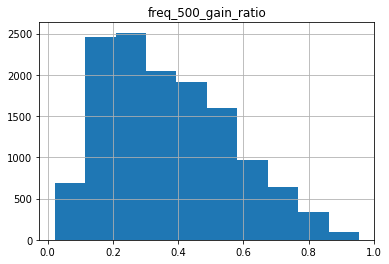

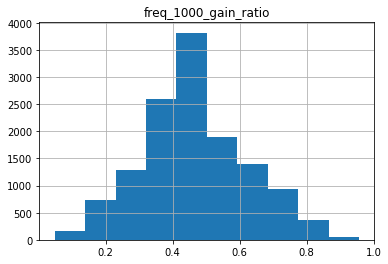

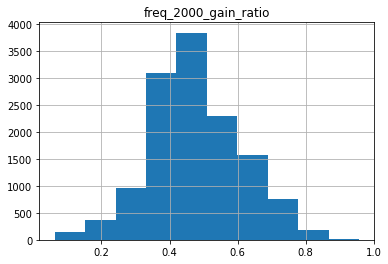

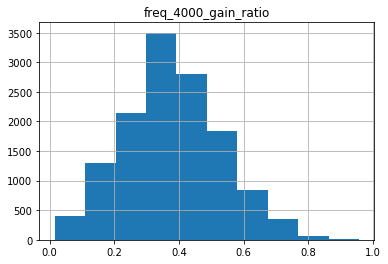

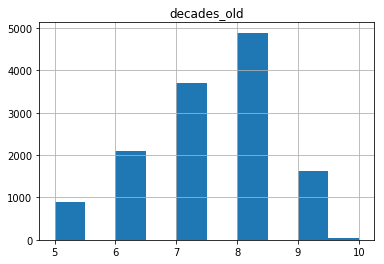

In [8]:
for feature in ['freq_500_gain_ratio', 'freq_1000_gain_ratio', 'freq_2000_gain_ratio', 'freq_4000_gain_ratio', 'decades_old']:
    display.display(equipment_success_valid.hist(feature))

In [9]:
def scaleInner(df, feature):
    stats = df[feature].describe();
    std = stats['std']
    mean = stats['mean']
    df[feature + '_scaled'] = (df[feature] - mean)/std
    return df

def scale(df, features):
    scaledDf = df.copy()
    for feature in features:
        scaleInner(scaledDf, feature)
    return scaledDf        

In [10]:
def success_ratio(equipment_success, freq, multiplier, threshold ):
    data = pd.value_counts(
        equipment_success['freq_' + freq + '_gain'] > (equipment_success['freq_' + freq] * multiplier) - threshold
    )  
    return data[True]/(data[False] + data[True])

In [11]:
[success_ratio(equipment_success_valid, '500', 0.5, 5),
success_ratio(equipment_success_valid, '1000', 0.5, 5),
success_ratio(equipment_success_valid, '2000', 0.5, 5),
success_ratio(equipment_success_valid, '4000', 0.5, 5)]

[0.3628271856377763,
 0.6090367353096477,
 0.6254808780267028,
 0.3193030097307083]

In [12]:
def model_good_prediction_ratio(targets, predictions, max_distance):
    predictionsDiff = (targets - predictions).apply (lambda x: abs(x))
    return len(list(filter(lambda x: x < max_distance, predictionsDiff)))/len(predictionsDiff)

In [13]:
equipment_success = equipment_success_valid.copy() #[(equipment_success_valid['isMale'] == 0)
                                           # & (equipment_success_valid['decades_old'] == 7)
                                           #].copy()

equipment_success

,patient_id,center_id,months_since_equipped,average_loss,high_loss,low_loss,id,age_in_months_at_equipped_start,freq_500,freq_1000,...,freq_4000_over_freq_1000,freq_500_gain,freq_1000_gain,freq_2000_gain,freq_4000_gain,freq_500_gain_ratio,freq_1000_gain_ratio,freq_2000_gain_ratio,freq_4000_gain_ratio,valid
4,496,27,46,61.2,70.0,51.7,1100532,929.0,60.0,45.0,...,1.8,30.0,15.0,25.0,30.0,0.5,0.3,0.4,0.4,True
10,642,27,67,47.5,57.5,31.7,1100644,788.0,30.0,40.0,...,1.5,10.0,15.0,30.0,20.0,0.3,0.4,0.5,0.3,True
11,642,27,67,48.8,58.8,35.0,1100142,788.0,30.0,45.0,...,1.4,5.0,20.0,30.0,25.0,0.2,0.4,0.5,0.4,True
13,664,36,42,50.0,68.8,21.2,1259060,809.0,25.0,25.0,...,3.8,5.0,10.0,25.0,35.0,0.2,0.4,0.5,0.4,True
14,665,27,61,61.2,62.5,60.0,1100692,827.0,65.0,65.0,...,1.0,10.0,35.0,20.0,35.0,0.2,0.5,0.4,0.5,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86133,288373,66,76,72.5,87.9,54.0,1174022,728.0,50.0,60.0,...,1.6,20.0,30.0,55.0,50.0,0.4,0.5,0.6,0.5,True
86148,288500,56,84,61.2,76.4,41.2,1267243,868.0,35.0,55.0,...,1.5,5.0,25.0,40.0,40.0,0.1,0.5,0.6,0.5,True
86154,288539,1295,23,46.2,55.7,41.2,1244190,591.0,40.0,45.0,...,1.3,5.0,10.0,10.0,15.0,0.1,0.2,0.2,0.2,True
86161,288599,895,53,108.8,108.8,106.2,1264526,891.0,105.0,110.0,...,1.0,70.0,85.0,90.0,80.0,0.7,0.8,0.8,0.7,True


## Keras

In [14]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input
from keras import optimizers



In [15]:
keras.__version__

'2.2.4'

In [16]:
def model_good_prediction_ratio_array(targets, predictions, max_distance):
    predictionsDiff = list(map(lambda x: abs(x), list(targets - predictions)))
    return len(list(filter(lambda x: x < max_distance, predictionsDiff)))/len(predictionsDiff)

In [17]:
equipment_success_valid = scale(equipment_success_valid, ['freq_500', 'freq_1000', 'freq_2000', 'freq_4000', 'decades_old', 'age_in_months_at_equipped_start'])


equipment_success_all = equipment_success_valid.copy()
#[(equipment_success_valid['isFemale'] == 1)
#                                            & (equipment_success_valid['decades_old'] == 8)
#                                           ].copy()

equipment_success = equipment_success_all.sample(frac=1)
equipment_success = equipment_success.head(1000)
 
equipment_success

,patient_id,center_id,months_since_equipped,average_loss,high_loss,low_loss,id,age_in_months_at_equipped_start,freq_500,freq_1000,...,freq_1000_gain_ratio,freq_2000_gain_ratio,freq_4000_gain_ratio,valid,freq_500_scaled,freq_1000_scaled,freq_2000_scaled,freq_4000_scaled,decades_old_scaled,age_in_months_at_equipped_start_scaled
71379,244427,1098,17,70.0,79.3,60.0,1280541,1000.0,60.0,65.0,...,0.5,0.6,0.6,True,0.2,0.2,0.4,0.3,0.6,0.9
11886,130739,147,18,45.2,61.9,23.8,1122468,973.0,21.0,27.0,...,0.3,0.5,0.4,True,-1.5,-1.5,0.2,-0.5,0.6,0.7
42929,185702,658,59,76.2,74.0,68.8,1154017,886.0,75.0,60.0,...,0.4,0.4,0.5,True,0.9,-0.0,0.2,1.4,-0.3,0.0
5241,76532,27,131,61.2,70.0,56.7,1100713,705.0,60.0,60.0,...,0.6,0.5,0.2,True,0.2,-0.0,-0.3,-0.4,-1.2,-1.4
10094,124637,263,32,112.5,113.3,110.0,1085233,1008.0,110.0,110.0,...,0.8,0.7,0.6,True,2.4,2.3,2.5,2.2,0.6,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12570,131625,263,34,68.8,71.7,65.0,1086290,724.0,60.0,70.0,...,0.6,0.6,0.5,True,0.2,0.4,0.2,0.1,-1.2,-1.2
60005,218783,414,41,50.0,59.2,28.8,1143006,732.0,25.0,40.0,...,0.1,0.2,0.2,True,-1.3,-0.9,-0.3,0.1,-1.2,-1.2
528,2220,74,22,53.8,61.0,41.2,1110756,606.0,35.0,55.0,...,0.5,0.7,0.5,True,-0.9,-0.2,-0.3,-0.4,-2.1,-2.1
14919,135431,156,27,51.5,61.4,39.5,1172192,992.0,38.0,44.0,...,0.4,0.4,0.2,True,-0.7,-0.7,-0.5,-0.3,0.6,0.9


In [18]:
features = [
   "age_in_months_at_equipped_start_scaled",
    "isMale",
    "isFemale",
    "isLeftEar",
    "isRightEar",
    'freq_500_scaled',
    'freq_1000_scaled',
    'freq_2000_scaled', 
    'freq_4000_scaled',
    #'freq_500_over_freq_1000',
    #'freq_2000_over_freq_1000',
    #'freq_4000_over_freq_1000'
    
]

data = (equipment_success[features].values)
labels = (equipment_success['eq_freq_2000'].values)

model_good_prediction_ratio_array(labels, np.average(labels), 5)

0.514

In [19]:


model = Sequential([
    Dense(9, input_dim=len(features)),
    Activation('sigmoid'),
    Dense(9, input_dim=6),
    Activation('sigmoid'),
    Dense(9, input_dim=6),
    Activation('sigmoid'),
    Dense(1),
])


sgd = optimizers.SGD(lr=0.05)


model.compile(optimizer=sgd,
              loss='mean_squared_error',       
              metrics=['mean_squared_error'])  


                         


history = model.fit(data, labels, epochs=200, batch_size=None,steps_per_epoch=100,
          validation_split=0.2, 
                    validation_steps=100,
                   verbose=1)

Train on 800 samples, validate on 200 samples
Epoch 1/200
100/100 [==============================] - 0s 4ms/step - loss: 80.4874 - mean_squared_error: 80.4874 - val_loss: 89.2483 - val_mean_squared_error: 89.2483
Epoch 2/200
100/100 [==============================] - 0s 2ms/step - loss: 67.9863 - mean_squared_error: 67.9863 - val_loss: 89.1105 - val_mean_squared_error: 89.1105
Epoch 3/200
100/100 [==============================] - 0s 3ms/step - loss: 67.3707 - mean_squared_error: 67.3707 - val_loss: 82.2062 - val_mean_squared_error: 82.2062
Epoch 4/200
100/100 [==============================] - 0s 3ms/step - loss: 56.1255 - mean_squared_error: 56.1255 - val_loss: 68.2586 - val_mean_squared_error: 68.2586
Epoch 5/200
100/100 [==============================] - 0s 2ms/step - loss: 54.3775 - mean_squared_error: 54.3775 - val_loss: 67.7652 - val_mean_squared_error: 67.7652
Epoch 6/200
100/100 [==============================] - 0s 3ms/step - loss: 53.5081 - mean_squared_error: 53.5081 - val_

100/100 [==============================] - 0s 3ms/step - loss: 33.9616 - mean_squared_error: 33.9616 - val_loss: 61.6862 - val_mean_squared_error: 61.6862
Epoch 50/200
100/100 [==============================] - 0s 2ms/step - loss: 33.8675 - mean_squared_error: 33.8675 - val_loss: 59.9444 - val_mean_squared_error: 59.9444
Epoch 51/200
100/100 [==============================] - 0s 3ms/step - loss: 33.8220 - mean_squared_error: 33.8220 - val_loss: 61.2535 - val_mean_squared_error: 61.2535
Epoch 52/200
100/100 [==============================] - 0s 3ms/step - loss: 33.7207 - mean_squared_error: 33.7207 - val_loss: 62.2169 - val_mean_squared_error: 62.2169
Epoch 53/200
100/100 [==============================] - 0s 2ms/step - loss: 33.7326 - mean_squared_error: 33.7326 - val_loss: 60.4659 - val_mean_squared_error: 60.4659
Epoch 54/200
100/100 [==============================] - 0s 3ms/step - loss: 33.6030 - mean_squared_error: 33.6030 - val_loss: 62.7094 - val_mean_squared_error: 62.7094
Epoch

Epoch 98/200
100/100 [==============================] - 0s 2ms/step - loss: 32.0892 - mean_squared_error: 32.0892 - val_loss: 59.9880 - val_mean_squared_error: 59.9880
Epoch 99/200
100/100 [==============================] - 0s 2ms/step - loss: 32.0802 - mean_squared_error: 32.0802 - val_loss: 60.0843 - val_mean_squared_error: 60.0843
Epoch 100/200
100/100 [==============================] - 0s 2ms/step - loss: 32.0806 - mean_squared_error: 32.0806 - val_loss: 62.3203 - val_mean_squared_error: 62.3203
Epoch 101/200
100/100 [==============================] - 0s 2ms/step - loss: 32.0316 - mean_squared_error: 32.0316 - val_loss: 61.1549 - val_mean_squared_error: 61.1549
Epoch 102/200
100/100 [==============================] - 0s 2ms/step - loss: 32.0957 - mean_squared_error: 32.0957 - val_loss: 62.1262 - val_mean_squared_error: 62.1262
Epoch 103/200
100/100 [==============================] - 0s 2ms/step - loss: 32.0225 - mean_squared_error: 32.0225 - val_loss: 60.6186 - val_mean_squared_err

100/100 [==============================] - 0s 3ms/step - loss: 31.2333 - mean_squared_error: 31.2333 - val_loss: 61.5777 - val_mean_squared_error: 61.5777
Epoch 147/200
100/100 [==============================] - 0s 3ms/step - loss: 31.1139 - mean_squared_error: 31.1139 - val_loss: 61.6933 - val_mean_squared_error: 61.6933
Epoch 148/200
100/100 [==============================] - 0s 2ms/step - loss: 31.2480 - mean_squared_error: 31.2480 - val_loss: 61.4392 - val_mean_squared_error: 61.4392
Epoch 149/200
100/100 [==============================] - 0s 3ms/step - loss: 31.0993 - mean_squared_error: 31.0993 - val_loss: 61.6883 - val_mean_squared_error: 61.6883
Epoch 150/200
100/100 [==============================] - 0s 4ms/step - loss: 31.1580 - mean_squared_error: 31.1580 - val_loss: 61.6077 - val_mean_squared_error: 61.6077
Epoch 151/200
100/100 [==============================] - 0s 3ms/step - loss: 31.0793 - mean_squared_error: 31.0793 - val_loss: 61.5128 - val_mean_squared_error: 61.5128


100/100 [==============================] - 0s 3ms/step - loss: 30.7136 - mean_squared_error: 30.7136 - val_loss: 63.4441 - val_mean_squared_error: 63.4441
Epoch 195/200
100/100 [==============================] - 0s 3ms/step - loss: 30.7325 - mean_squared_error: 30.7325 - val_loss: 62.6356 - val_mean_squared_error: 62.6356
Epoch 196/200
100/100 [==============================] - 0s 3ms/step - loss: 30.7652 - mean_squared_error: 30.7652 - val_loss: 63.9575 - val_mean_squared_error: 63.9575
Epoch 197/200
100/100 [==============================] - 0s 3ms/step - loss: 30.6862 - mean_squared_error: 30.6862 - val_loss: 63.3693 - val_mean_squared_error: 63.3693
Epoch 198/200
100/100 [==============================] - 0s 2ms/step - loss: 30.7287 - mean_squared_error: 30.7287 - val_loss: 62.6428 - val_mean_squared_error: 62.6428
Epoch 199/200
100/100 [==============================] - 0s 2ms/step - loss: 30.6852 - mean_squared_error: 30.6852 - val_loss: 63.2506 - val_mean_squared_error: 63.2506


In [20]:
from operator import itemgetter

a, b = min(enumerate(history.history['loss']), key=itemgetter(1)) 
[a, math.sqrt(b)]

[198, 5.539419872124141]

In [21]:
predictions = model.predict(data).transpose()[0]
[model_good_prediction_ratio_array(labels, predictions, 5),
 model_good_prediction_ratio_array(labels, np.average(labels), 5)]


[0.655, 0.514]

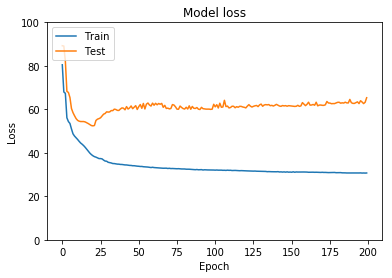

In [22]:

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.ylim(0, 100)
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [23]:
test_dataset = equipment_success_all.copy() #[(equipment_success_valid['isMale'] == 0)
                                           # & (equipment_success_valid['decades_old'] == 7)
                                           #].copy()
        
test_dataset = test_dataset.sample(frac=1)
test_dataset = test_dataset.tail(1000)
test_data = (test_dataset[features].values)
test_labels = (test_dataset['eq_freq_2000'].values)

test_predictions = model.predict(test_data).transpose()[0]
[model_good_prediction_ratio_array(test_labels, test_predictions, 5),
 model_good_prediction_ratio_array(test_labels, np.average(test_labels), 5)]


[0.548, 0.541]

In [24]:
test_labels - test_predictions

array([ 2.05080795e+00, -7.94754410e+00, -1.29538536e+01, -2.95101547e+00,
        3.27393723e+00,  8.27403069e+00, -2.28575363e+01, -1.57872200e+00,
        4.10610580e+00, -6.93192291e+00,  2.07655716e+00, -2.19954643e+01,
       -2.95190430e+00,  3.52158165e+00, -1.57377625e+00,  3.27444458e+00,
       -2.95045471e+00,  2.04628754e+00, -1.82958221e+00, -1.72612762e+00,
       -7.61500168e+00, -1.73098564e+00,  2.04937744e+00,  3.27481079e+00,
        1.47110004e+01,  1.25687962e+01, -1.72239685e+00,  1.32738705e+01,
       -3.20412064e+00,  8.34257889e+00, -2.95625305e+00,  2.74271011e-01,
       -1.73409271e+00, -1.72612953e+00, -1.29504852e+01,  7.04953384e+00,
        3.12254906e+00, -1.67822075e+00, -7.96102142e+00,  4.94232178e-02,
       -1.19523697e+01,  2.30931072e+01,  1.32749939e+01, -2.95349121e+00,
       -3.82720566e+00,  3.26380539e+00,  2.00729370e+00, -7.95290375e+00,
        3.72333717e+00,  2.04780197e+00, -2.95038605e+00, -1.70900726e+00,
        3.27503395e+00,  